In [1]:
import torch
import torchvision
import torchvision.datasets
import torchvision.transforms
import torch.utils.data
import torch.nn
import os
import numpy as np
import time
from matplotlib import pyplot as plot

Number of train samples: 60000
Number of test samples: 10000


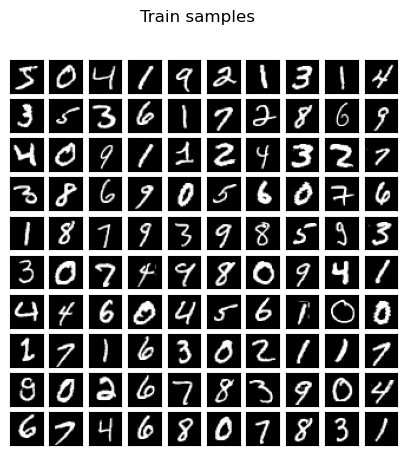

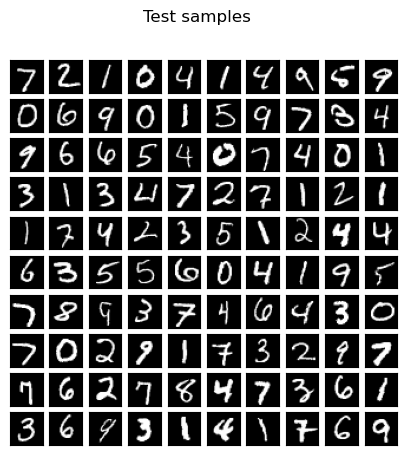

In [2]:
dir_name = os.getcwd()

def show_images(images, title):
    num_showed_imgs_x = 10
    num_showed_imgs_y = 10

    figsize = (5, 5)
    fig, axes = plot.subplots(num_showed_imgs_y, num_showed_imgs_x, figsize = figsize)
    fig.suptitle(title)
    plot.setp(plot.gcf().get_axes(), xticks = [], yticks = [])
    for i, ax in enumerate(axes.flat):
        img = images[i][0].numpy().transpose(1, 2, 0).squeeze(axis = 2)
        ax.imshow(img, cmap = 'gray')

train_dataset = torchvision.datasets.MNIST(
    root = dir_name, train = True, download = True,
    transform = torchvision.transforms.ToTensor()
)
test_dataset = torchvision.datasets.MNIST(
    root = dir_name, train = False, download = True,
    transform = torchvision.transforms.ToTensor()
)

print('Number of train samples: {}'.format(len(train_dataset)))
show_images(train_dataset, 'Train samples')

print('Number of test samples: {}'.format(len(test_dataset)))
show_images(test_dataset, 'Test samples')

In [3]:
epochs = 20
batch_size = 64
hide_dim = 300
learning_rate = 0.1
image_resolution = 28 * 28
classes = 10

train_data_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size = batch_size, shuffle = True
)
test_data_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size = batch_size, shuffle = False
)

In [4]:
class Backpropagation(torch.nn.Module):
    def __init__(self):
        super(Backpropagation, self).__init__()
# 2 полносвязных слоя
        self.linear_1 = torch.nn.Linear(image_resolution, hide_dim)
        self.linear_2 = torch.nn.Linear(hide_dim, classes)
        
    def forward(self, x):
        out_1 = self.linear_1(x)
        activate_1 = torch.nn.ReLU()(out_1)
        out_2 = self.linear_2(activate_1)
        return out_2
    
torch_model =  Backpropagation()
print(torch_model)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch_model.to(device)

loss_function = torch.nn.CrossEntropyLoss()
# реализует стохастический градиентный спуск
optimizer = torch.optim.SGD(torch_model.parameters(), lr = learning_rate)

Backpropagation(
  (linear_1): Linear(in_features=784, out_features=300, bias=True)
  (linear_2): Linear(in_features=300, out_features=10, bias=True)
)


In [5]:
def get_accuracy(data_loader, model):
    tp = 0
    n = 0
    with torch.no_grad(): # деактивация вычисления градиентов
        for images, labels in data_loader: # проход по всем данным
            # Конвертация тензора [B, C, W, H] к формату [B, W * H]
            images = images.reshape(-1, image_resolution)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            n += labels.size(0)
            tp += (predicted == labels).sum() # количество совпадений
    return tp / n

for epoch in range(epochs):  # проход по эпохам
    start = time.time()
    for i, (images, labels) in enumerate(train_data_loader):
        # Преобразование тензора [B, C, W, H] к формату [B, W * H]
        images = images.view(-1, image_resolution).requires_grad_().to(device)
        labels = labels.to(device)

        # Прямой проход
        outputs = torch_model(images)
        loss = loss_function(outputs, labels)

        # Обратный проход
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    duration = time.time() - start
    print('Epoch[{}]: accuracy = {}, time = {}'.format(epoch, get_accuracy(train_data_loader, torch_model), duration))

Epoch[0]: accuracy = 0.9253000020980835, time = 23.671454668045044
Epoch[1]: accuracy = 0.9469166398048401, time = 23.594707250595093
Epoch[2]: accuracy = 0.9606666564941406, time = 23.788549184799194
Epoch[3]: accuracy = 0.9700333476066589, time = 23.882524251937866
Epoch[4]: accuracy = 0.9745166897773743, time = 24.117764711380005
Epoch[5]: accuracy = 0.9793833494186401, time = 23.956803560256958
Epoch[6]: accuracy = 0.9818166494369507, time = 23.796956777572632
Epoch[7]: accuracy = 0.9844499826431274, time = 24.17933940887451
Epoch[8]: accuracy = 0.986133337020874, time = 23.95789122581482
Epoch[9]: accuracy = 0.9873999953269958, time = 23.70419454574585
Epoch[10]: accuracy = 0.9862499833106995, time = 23.900546312332153
Epoch[11]: accuracy = 0.9905999898910522, time = 23.727736711502075
Epoch[12]: accuracy = 0.9919499754905701, time = 24.007604360580444
Epoch[13]: accuracy = 0.9923833608627319, time = 25.74753212928772
Epoch[14]: accuracy = 0.9929666519165039, time = 25.67373442649

In [6]:
class Propagation(torch.nn.Module):
    def __init__(self):
        super(Propagation, self).__init__()        
        self.W = torch.empty(hide_dim, image_resolution)
        self.w = torch.empty(hide_dim, 1)
        self.V = torch.empty(classes, hide_dim)
        self.v = torch.empty(classes, 1)

        torch.nn.init.xavier_normal_(self.W)
        torch.nn.init.xavier_normal_(self.w)
        torch.nn.init.xavier_normal_(self.V)
        torch.nn.init.xavier_normal_(self.v)


    def forward(self, images):
        self.images = images
        # print(images.size(), self.W.size())
        self.out_1 = images @ self.W.transpose(0,1) + self.w.transpose(0, 1)
        self.activate_1 = torch.nn.ReLU()(self.out_1)
        self.out_2 = self.activate_1 @ self.V.transpose(0,1) + self.v.transpose(0, 1)
        self.activate_2 = torch.nn.Softmax()(self.out_2)
        return self.activate_2

    def backward(self, labels):
        size = labels.shape[0]
        y = torch.zeros(size, classes)
        for i in range(size):
            y[i][labels[i]] = 1

        delta_t = (self.activate_2 - y) / batch_size
        delta_z = (delta_t @ self.V)
        delta_s = torch.mul(delta_z, self.out_1 > 0)

        dV = delta_t.transpose(0, 1) @ self.activate_1
        dv = torch.sum(delta_t, 0).unsqueeze(1)
        dW = delta_s.transpose(0,1) @ self.images
        dw = torch.sum(delta_s, 0).unsqueeze(1)

        self.W -= learning_rate * dW
        self.w -= learning_rate * dw
        self.V -= learning_rate * dV
        self.v -= learning_rate * dv
    
model = Propagation()
model.to(device);


In [7]:
for epoch in range(epochs):  # проход по эпохам
    start = time.time()
    for i, (images, labels) in enumerate(train_data_loader):
        # Преобразование тензора [B, C, W, H] к формату [B, W * H]
        images = images.view(-1, image_resolution).requires_grad_().to(device)
        labels = labels.to(device)
        model.forward(images)
        model.backward(labels)
    duration = time.time() - start
    print('Epoch[{}]: accuracy = {}, time = {}'.format(epoch, get_accuracy(train_data_loader, model), duration))

C:\Users\Pavel-PC\AppData\Local\Temp\ipykernel_47540\621043933.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  self.activate_2 = torch.nn.Softmax()(self.out_2)


Epoch[0]: accuracy = 0.937333345413208, time = 19.181308269500732
Epoch[1]: accuracy = 0.9580666422843933, time = 19.409400701522827
Epoch[2]: accuracy = 0.9676499962806702, time = 19.51663851737976
Epoch[3]: accuracy = 0.9737833142280579, time = 19.61880111694336
Epoch[4]: accuracy = 0.9785000085830688, time = 20.348892211914062
Epoch[5]: accuracy = 0.9819999933242798, time = 19.968942642211914
Epoch[6]: accuracy = 0.984416663646698, time = 20.41089916229248
Epoch[7]: accuracy = 0.9850500226020813, time = 20.903160572052002
Epoch[8]: accuracy = 0.9885666370391846, time = 21.04307794570923
Epoch[9]: accuracy = 0.9889833331108093, time = 21.717391967773438
Epoch[10]: accuracy = 0.9912499785423279, time = 22.14834713935852
Epoch[11]: accuracy = 0.9922000169754028, time = 22.566960096359253
Epoch[12]: accuracy = 0.993399977684021, time = 23.062790393829346
Epoch[13]: accuracy = 0.9943166375160217, time = 24.02529263496399
Epoch[14]: accuracy = 0.9950000047683716, time = 24.971622705459595

In [8]:
print('Test accuracy: {}'.format(get_accuracy(test_data_loader, model)))

C:\Users\Pavel-PC\AppData\Local\Temp\ipykernel_47540\621043933.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  self.activate_2 = torch.nn.Softmax()(self.out_2)


Test accuracy: 0.9805999994277954
